# Does a job training program improve the earnings of disadvantaged workers?

In [251]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import scipy
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve


# Visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

## For this case, you will likely need approximately 4.5 hours to complete mandatory exercises.

## Introduction

**Business Context.** In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.

<img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training">

The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.

**Business Problem.** Your goal is to evaluate **whether the job training program *causes* the earnings of disadvantaged workers to go up**.

**Analytical Context.** In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.

## Examining the data

The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is `re78` in which we want to know if there was an increase in earnings in 1978:

1. **age**: age in years
2. **educ**: years of schooling
3. **black**: indicator variable for blacks
4. **hisp**: indicator variable for Hispanics
5. **married**: indicator variable for martial status
6. **nodegr**: indicator variable for high school diploma
7. **re74**: real earnings in 1974
8. **re75**: real earnings in 1975
9. **re78**: real earnings in 1978 - this is the outcome of interest
10. **treat**: an indicator variable whether the worker was enrolled in the training workshop

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### Exercise 1: (20 min)

#### 1.1

Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?

In [3]:
lalonde_df.mean(axis=0)

# There was a reduction the average wage of the observed population between 1974 & 1975.

treat          0.301303
age           27.363192
educ          10.268730
black          0.395765
hispan         0.117264
married        0.415309
nodegree       0.630293
re74        4557.546569
re75        2184.938207
re78        6792.834483
dtype: float64

In [14]:
(lalonde_df[(lalonde_df['re75'] - lalonde_df['re74']) < 0].shape[0]/lalonde_df.shape[0])*100
# The percentage of the population who saw a decrease in income was 46.41%

46.416938110749186

**Answer.** 

#### 1.2 
    
What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?

**Note:** Remember that the *treatment and control groups* correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  `treat` column.

**Answer.**

In [18]:
(lalonde_df[(lalonde_df['treat']) == 1].shape[0]/lalonde_df.shape[0])*100
# 30.13% of the workers are in the treatment group.

30.130293159609124

In [21]:
lalonde_df[(lalonde_df['treat']) == 1]['re78']

NSW1       9930.0460
NSW2       3595.8940
NSW3      24909.4500
NSW4       7506.1460
NSW5        289.7899
             ...    
NSW181    15952.6000
NSW182    36646.9500
NSW183    12803.9700
NSW184     3786.6280
NSW185     4181.9420
Name: re78, Length: 185, dtype: float64

In [25]:
scipy.stats.ttest_ind(lalonde_df[(lalonde_df['treat']) == 1]['re78'], lalonde_df[(lalonde_df['treat']) == 0]['re78'], equal_var=False)
# We don't reject the null hypothesis the average income between control & treatment groups is equal.

Ttest_indResult(statistic=-0.9377296979393183, pvalue=0.3490766555566698)

#### 1.3

Does your previous result mean that the treatment had a negative impact? Why or why not?

**Answer.**

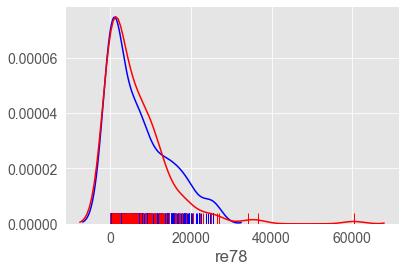

In [329]:
sns.distplot(lalonde_df[lalonde_df['treat'] == 0]['re78'], hist=False, rug=True, color = 'b')
sns.distplot(lalonde_df[lalonde_df['treat'] == 1]['re78'], hist=False, rug=True, color = 'r')
# Comparing the distributions of earnings between control & treatment groups, there is not seem to be
# neither a negative effect nor a significant effect.

_____

Before we start our exploration on causality, let's perform some simple setup:

1. We separate the `treat` (treatment) indicator from our dataset. We will want to use this as our objective variable to fit models to later
2. We are interested in knowing the treatment effect on `re78` (revenue/earnings in 1978)

In [26]:
#First, let's reset the indexes
cleaned_df=lalonde_df.reset_index().drop(['index'],axis=1)

#Create seperate structure for data and target 
treatment = cleaned_df['treat']
rev78 = cleaned_df['re78']
cleaned_df = cleaned_df.drop(['treat', 're78'], axis=1)
cleaned_df.head()

,age,educ,black,hispan,married,nodegree,re74,re75
0,37,11,1,0,1,1,0.0,0.0
1,22,9,0,1,0,1,0.0,0.0
2,30,12,1,0,0,0,0.0,0.0
3,27,11,1,0,0,1,0.0,0.0
4,33,8,1,0,0,1,0.0,0.0


## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

### Exercise 2: (30 min)

#### 2.1

Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?

**Answer.**

In [38]:

def smd_covariates(covariate):
    a = cleaned_df[(treatment) == 1][covariate]
    b = cleaned_df[(treatment) == 0][covariate]
    var_a = a.var(ddof=1)
    var_b = b.var(ddof=1)
    #std deviation
    s = np.sqrt((var_a + var_b)/2)
    ## Calculate the t-statistics
    t = (a.mean() - b.mean())/np.sqrt(s)
    return t


print("Age: " + str(smd_covariates('age')))
print("Education Years: " + str(smd_covariates('educ')))
print("Black (Dummy): " + str(smd_covariates('black')))
print("Hispan (Dummy): " + str(smd_covariates('hispan')))
print("Married (Dummy): " + str(smd_covariates('married')))
print("No-Degree (Dummy): " + str(smd_covariates('nodegree')))

# Black, Married and Age covariates are imbalanced between control & treatment groups.

Age: -0.731843987336445
Education Years: 0.07032848125111991
Black (Dummy): 1.0334814506811696
Hispan (Dummy): -0.1513660425392663
Married (Dummy): -0.4825454757400639
No-Degree (Dummy): 0.16179515999781346


#### 2.2

Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.

**Answer.**

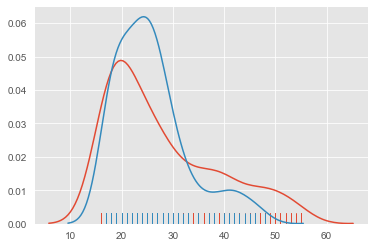

In [41]:
# Sort the dataframe by target
target_0 = cleaned_df[treatment == 0]
target_1 = cleaned_df[treatment == 1]
sns.distplot(target_0[['age']], hist=False, rug=True)
sns.distplot(target_1[['age']], hist=False, rug=True)

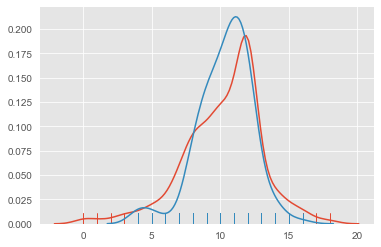

In [42]:
sns.distplot(target_0[['educ']], hist=False, rug=True)
sns.distplot(target_1[['educ']], hist=False, rug=True)

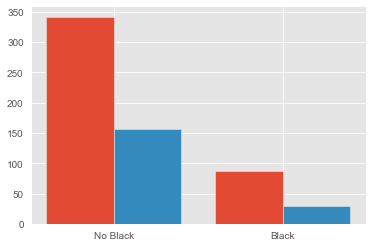

In [77]:
X = ['No Black','Black']
Y = target_0['black'].value_counts()
Z = target_1['black'].value_counts() #red
_X = np.arange(len(X))
plt.bar(_X - 0.2, Y, 0.4)
plt.bar(_X + 0.2, Z, 0.4)
plt.xticks(_X, X) # set labels manually
plt.show()

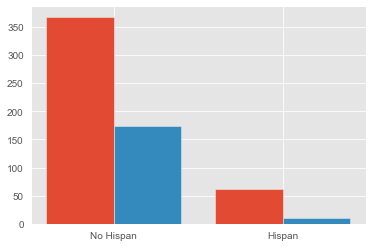

In [78]:
X = ['No Hispan','Hispan']
Y = target_0['hispan'].value_counts()
Z = target_1['hispan'].value_counts() #red
_X = np.arange(len(X))
plt.bar(_X - 0.2, Y, 0.4)
plt.bar(_X + 0.2, Z, 0.4)
plt.xticks(_X, X) # set labels manually
plt.show()

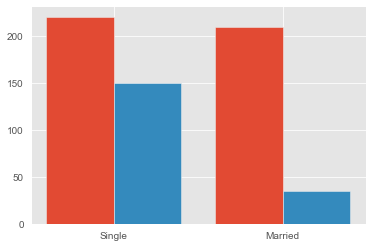

In [79]:
X = ['Single','Married']
Y = target_0['married'].value_counts()
Z = target_1['married'].value_counts() #red
_X = np.arange(len(X))
plt.bar(_X - 0.2, Y, 0.4)
plt.bar(_X + 0.2, Z, 0.4)
plt.xticks(_X, X) # set labels manually
plt.show()

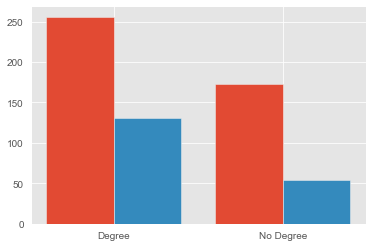

In [81]:
X = ['Degree','No Degree']
Y = target_0['nodegree'].value_counts()
Z = target_1['nodegree'].value_counts() #red
_X = np.arange(len(X))
plt.bar(_X - 0.2, Y, 0.4)
plt.bar(_X + 0.2, Z, 0.4)
plt.xticks(_X, X) # set labels manually
plt.show()

## Propensity score matching using logistic regression 

In order to balance the covariates of the control and treatment groups, we will use **matching**. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.
    
In Case 7.5 we used the *Euclidean distance* on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.

We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the **propensity score** helps us do the matching on select features in an efficient way. The key idea is that *the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results*. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:

$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)
 
As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.

### Exercise 3: (35 min)

#### 3.1 

Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. How would you interpret the predicted values output by the model? 

**Answer.**

In [83]:
clf = LogisticRegression(random_state=12345).fit(cleaned_df, treatment)
# Predicted values are the probability of participation in the program.

#### 3.2

Use `.predict()`  to obtain the propensity scores of individuals in our dataset. Save the the results with the name `pscore_logit` (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.

**Answer.**

In [88]:
pscore_logit = clf.predict_proba(cleaned_df)

In [175]:
pscore_logit = pd.DataFrame(pscore_logit).iloc[:,1]
pscore_logit

0      0.432245
1      0.133263
2      0.724405
3      0.660356
4      0.696809
         ...   
609    0.140849
610    0.100313
611    0.127155
612    0.545471
613    0.160543
Name: 1, Length: 614, dtype: float64

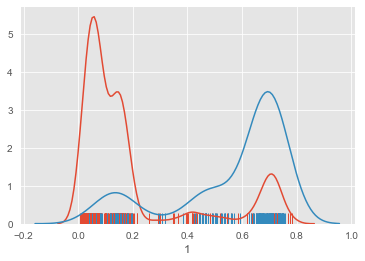

In [176]:
sns.distplot(pscore_logit[treatment == 0], hist=False, rug=True)
sns.distplot(pscore_logit[treatment == 1], hist=False, rug=True)

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

### Exercise 4 (50 min):

In this exercise, we will use the `sklearn.neighbors` function [`NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors) to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.

#### 4.1

Separate the propensity scores `pscore_logit` found in Exercise 3 for treatment and control groups. Call these `treat_pscores` and `control_pscores` respectively. Use the `control_pscores` to train a $k$-NN algorithm with $k=5$.

**Hint:** Load the model using `knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')`. You may want to reshape the control scores using `control_pscores.reshape(-1,1)`.

**Answer.**

In [181]:
control_pscores = pscore_logit[treatment == 0].values.reshape(-1,1)
treat_pscores = pscore_logit[treatment == 1].values.reshape(-1,1)

knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')
knn.fit(control_pscores)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

#### 4.2

Find the indices of the five nearest neighbors using the method `.kneighbors()` applied to `treat_pscores`. 

**Answer.**

In [194]:
kneighbors = pd.DataFrame(knn.kneighbors(treat_pscores, 5, return_distance=False))
kneighbors.columns = ['k1','k2','k3','k4','k5']
kneighbors

,k1,k2,k3,k4,k5
0,96,367,23,407,374
1,71,87,83,341,239
2,351,380,255,139,386
3,178,14,225,158,276
4,354,398,195,405,371
...,...,...,...,...,...
180,95,307,26,93,216
181,270,338,294,135,75
182,23,367,407,374,4
183,353,330,379,98,292


In [204]:
# Test:
treat_pscores[180]

array([0.30496243])

In [205]:
control_pscores[95]

array([0.29806654])

#### 4.3

Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of `DataFrames`, each with $185$ rows from the `lalonde_df`. The first should correspond to the treatment group and the second should correspond to the matched control group.

**Answer.**

In [206]:
treatment_group = cleaned_df[(treatment) == 1]
treatment_group

,age,educ,black,hispan,married,nodegree,re74,re75
0,37,11,1,0,1,1,0.00,0.00
1,22,9,0,1,0,1,0.00,0.00
2,30,12,1,0,0,0,0.00,0.00
3,27,11,1,0,0,1,0.00,0.00
4,33,8,1,0,0,1,0.00,0.00
...,...,...,...,...,...,...,...,...
180,33,12,1,0,1,0,20279.95,10941.35
181,25,14,1,0,1,0,35040.07,11536.57
182,35,9,1,0,1,1,13602.43,13830.64
183,35,8,1,0,1,1,13732.07,17976.15


In [207]:
matched_control_group = cleaned_df[treatment == 0].reset_index().drop(['index'],axis=1).iloc[np.array(kneighbors['k1']),:]
matched_control_group

,age,educ,black,hispan,married,nodegree,re74,re75
96,24,12,1,0,1,0,8573.7520,4293.1940
71,28,12,0,0,0,0,8256.3500,5279.6610
351,24,12,1,0,0,0,566.2281,0.0000
178,18,11,1,0,0,1,2068.9860,1623.8230
354,19,9,1,0,0,1,384.0163,0.0000
...,...,...,...,...,...,...,...,...
95,47,10,1,0,0,1,21918.3200,4323.6290
270,17,11,0,1,0,1,803.2994,248.8548
23,47,8,1,0,1,1,9275.1690,8543.4190
353,50,5,1,0,1,1,411.4460,0.0000


### Propensity score distribution plot after matching

Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.

### Exercise 5 (20 min):

Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.

**Answer.**

In [215]:
pscore_control_matching = pscore_logit[treatment == 0].reset_index().drop(['index'],axis=1).iloc[np.array(kneighbors['k1']),:]
pscore_control_matching = np.array(pscore_control_matching)

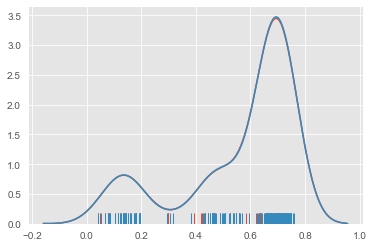

In [216]:
sns.distplot(pscore_control_matching, hist=False, rug=True)
sns.distplot(treat_pscores, hist=False, rug=True)
# The distributions of propensity scores are now very similar, which let us compare the impact of the program
# due to we have comparable samples in both groups.

### Exercise 6 (45 min):

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups **before matching**. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer.**

In [218]:
def asmd_covariates(covariate):
    a = treatment_group[covariate]
    b = matched_control_group[covariate]
    c = cleaned_df[(treatment) == 0][covariate]
    
    var_a = a.var(ddof=1)
    var_c = c.var(ddof=1)
    #std deviation
    s = np.sqrt((var_a + var_c)/2)
    ## Calculate the t-statistics
    t = (a.mean() - b.mean())/np.sqrt(s)
    return t


print("Age: " + str(asmd_covariates('age')))
print("Education Years: " + str(asmd_covariates('educ')))
print("Black (Dummy): " + str(asmd_covariates('black')))
print("Hispan (Dummy): " + str(asmd_covariates('hispan')))
print("Married (Dummy): " + str(asmd_covariates('married')))
print("No-Degree (Dummy): " + str(asmd_covariates('nodegree')))

# The ASMD values are lower than 2 in absolute values, so the samples are balanced.

Age: 0.8236696441036718
Education Years: 0.0034398493280957346
Black (Dummy): 0.008722649321100678
Hispan (Dummy): 0.05933843946026068
Married (Dummy): -0.08059646061611347
No-Degree (Dummy): 0.16490695739566705


### Exercise 7 (25 min):

Estimate the average effect of treatment on <font color='red'> wages (`re78`) </font> after matching. What do you conclude?

**Answer.**

In [280]:
control_effect = np.array(rev78[treatment == 0].reset_index().drop(['index'],axis=1).iloc[np.array(kneighbors['k1']),:])
treatment_effect = np.array(rev78[(treatment) == 1])

print('ATE Logit: '+ str(np.mean((treatment_effect - control_effect)/len(treatment_effect))))

ATE Logit: 3.0992712268809353


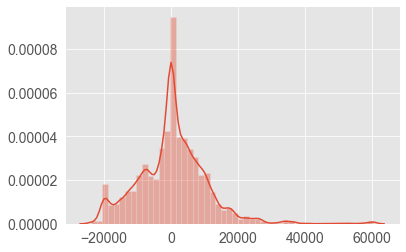

In [277]:
sns.distplot((treatment_effect - control_effect))
# The effect was too low comparing the means, so the impact didn't have significant effects on the population trained.

## Propensity score matching using decision trees and random forests

### Exercise 8 (Optional) - (70 min):

To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.

#### 8.1

Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. Use the `sklearn.tree` function `DecisionTreeRegressor(max_depth=4)` and call the new propensity scores `pscore_tree`.

**Answer.**

In [237]:
# Fit regression model
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(cleaned_df, treatment)
# Predict
pscore_tree = dt.predict(cleaned_df)

#### 8.2

Plot the decision tree regressor using the code

```
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree.png')
```

Replace `dt` with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated (less than 10 years of educ) Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)

**Answer.**

[Text(633.1473214285714, 1019.25, 'black <= 0.5\nmse = 0.211\nsamples = 614\nvalue = 0.301'),
 Text(332.14285714285717, 792.75, 're74 <= 16.654\nmse = 0.072\nsamples = 371\nvalue = 0.078'),
 Text(166.07142857142858, 566.25, 'age <= 18.5\nmse = 0.166\nsamples = 95\nvalue = 0.211'),
 Text(83.03571428571429, 339.75, 'married <= 0.5\nmse = 0.026\nsamples = 37\nvalue = 0.027'),
 Text(41.517857142857146, 113.25, 'mse = 0.0\nsamples = 33\nvalue = 0.0'),
 Text(124.55357142857144, 113.25, 'mse = 0.188\nsamples = 4\nvalue = 0.25'),
 Text(249.1071428571429, 339.75, 'married <= 0.5\nmse = 0.22\nsamples = 58\nvalue = 0.328'),
 Text(207.58928571428572, 113.25, 'mse = 0.25\nsamples = 34\nvalue = 0.5'),
 Text(290.625, 113.25, 'mse = 0.076\nsamples = 24\nvalue = 0.083'),
 Text(498.2142857142858, 566.25, 'age <= 23.5\nmse = 0.032\nsamples = 276\nvalue = 0.033'),
 Text(415.17857142857144, 339.75, 're75 <= 5164.95\nmse = 0.07\nsamples = 106\nvalue = 0.075'),
 Text(373.66071428571433, 113.25, 'mse = 0.04\n

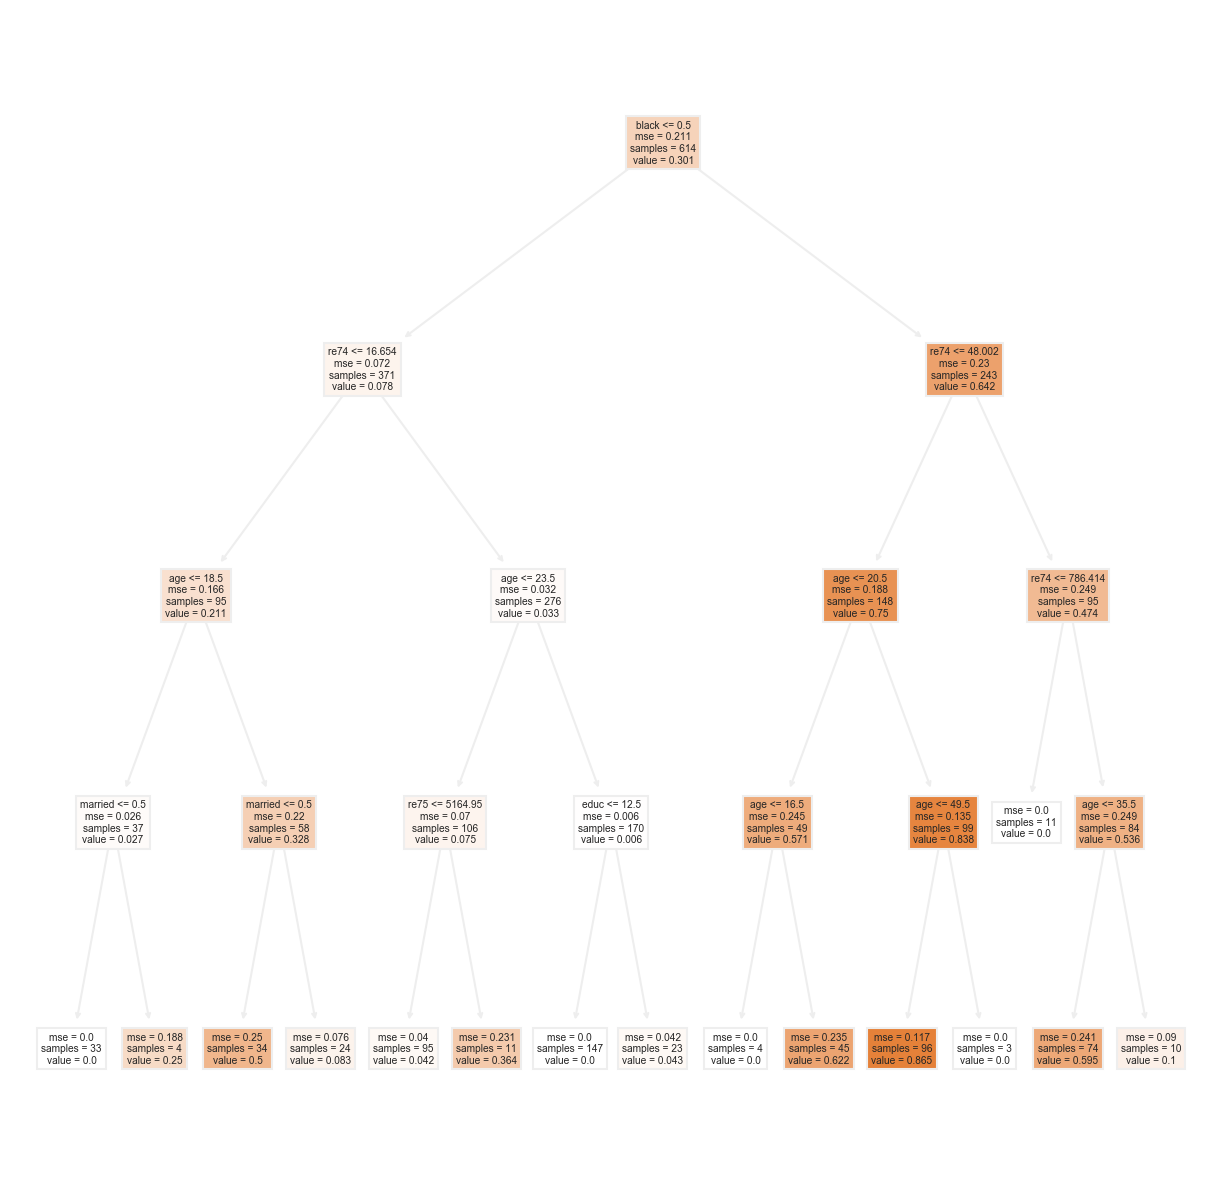

In [241]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=300)
tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns,class_names= ['no event','event'])

In [ ]:

# Use the plot to estimate the probability that a 24 year old, single, uneducated (less than 10 years of educ) Hispanic individual that earned 
#20000 in 1974 was enrolled in the employment program:
# Prob: 0.865.

# Do the same with a black man with the same characteristics.
# Prob: 0.

#### 8.3

Estimate the propensity scores now by using random forests. For the model, use the `sklearn.ensemble` function `RandomForestClassifier` with parameters `n_estimators=100, max_depth=4, random_state=42`. Then, use the method `predict_proba` to extract the propensity scores. Name the scores `pscore_forest`.

**Answer.**

In [274]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf.fit(cleaned_df, treatment)
# Predict
pscore_forest = rf.predict_proba(cleaned_df)
pscore_forest = pd.DataFrame(pscore_forest).iloc[:,1]

#### 8.4

Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model *seems* to do the best job?

**Answer.**

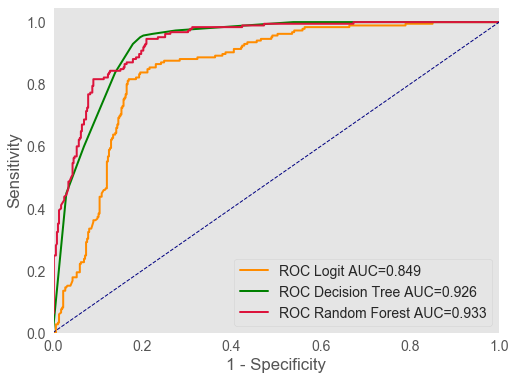

In [276]:
def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test, pred_proba) #.ravel()
    roc_auc = roc_auc_score(y_test, pred_proba)
    return fpr, tpr, roc_auc


plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(treatment, pscore_logit)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC Logit AUC={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(treatment, np.array(pscore_tree))
plt.plot(fpr, tpr, color='green', lw=2,
         label='ROC Decision Tree AUC={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(treatment, np.array(pscore_forest))
plt.plot(fpr, tpr, color='crimson', lw=2,
         label='ROC Random Forest AUC={0:.3f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

# The best model is Random Forest with AUC = 0.933

#### 8.5

Consider the following statement:

>  "*A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.*"

Is the statement true or false? Explain. 

**Answer.**

In [ ]:
# It's true, because it means it will estimate with higher accuracy the most similar individuals
# of the control group to the individuals of the treatment group.

#### 8.6

Repeat the matching procedure now with the estimated propensity scores `pscore_tree` and `pscore_forest`. Assess the covariate balances and estimate the average effect of treatment on wages (`re78`) after matching. Compare your results. 

**Answer.**

In [282]:
control_pscores = pscore_tree[treatment == 0].reshape(-1,1)
treat_pscores = pscore_tree[treatment == 1].reshape(-1,1)

knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')
knn.fit(control_pscores)
kneighbors = pd.DataFrame(knn.kneighbors(treat_pscores, 5, return_distance=False))
kneighbors.columns = ['k1','k2','k3','k4','k5']

matched_control_group = cleaned_df[treatment == 0].reset_index().drop(['index'],axis=1).iloc[np.array(kneighbors['k1']),:]

print("Age: " + str(asmd_covariates('age')))
print("Education Years: " + str(asmd_covariates('educ')))
print("Black (Dummy): " + str(asmd_covariates('black')))
print("Hispan (Dummy): " + str(asmd_covariates('hispan')))
print("Married (Dummy): " + str(asmd_covariates('married')))
print("No-Degree (Dummy): " + str(asmd_covariates('nodegree')))

control_effect = np.array(rev78[treatment == 0].reset_index().drop(['index'],axis=1).iloc[np.array(kneighbors['k1']),:])
treatment_effect = np.array(rev78[(treatment) == 1])

print('ATE Decision Trees: '+ str(np.mean((treatment_effect - control_effect)/len(treatment_effect))))

# Married and Age are not balanced covariates
# The average effect on incomes is U$ 21.

Age: -2.53175680194122
Education Years: -0.736127756212555
Black (Dummy): 0.0
Hispan (Dummy): 0.04944869955021723
Married (Dummy): -0.4271612412654014
No-Degree (Dummy): 0.10993797159711143
ATE Decision Trees: 21.9772998422206


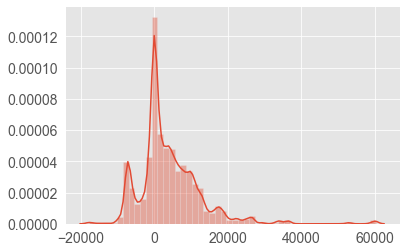

In [283]:
sns.distplot((treatment_effect - control_effect))

In [285]:
control_pscores = pscore_forest[treatment == 0].values.reshape(-1,1)
treat_pscores = pscore_forest[treatment == 1].values.reshape(-1,1)

knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')
knn.fit(control_pscores)
kneighbors = pd.DataFrame(knn.kneighbors(treat_pscores, 5, return_distance=False))
kneighbors.columns = ['k1','k2','k3','k4','k5']

matched_control_group = cleaned_df[treatment == 0].reset_index().drop(['index'],axis=1).iloc[np.array(kneighbors['k1']),:]

print("Age: " + str(asmd_covariates('age')))
print("Education Years: " + str(asmd_covariates('educ')))
print("Black (Dummy): " + str(asmd_covariates('black')))
print("Hispan (Dummy): " + str(asmd_covariates('hispan')))
print("Married (Dummy): " + str(asmd_covariates('married')))
print("No-Degree (Dummy): " + str(asmd_covariates('nodegree')))

control_effect = np.array(rev78[treatment == 0].reset_index().drop(['index'],axis=1).iloc[np.array(kneighbors['k1']),:])
treatment_effect = np.array(rev78[(treatment) == 1])

print('ATE Random Forests: '+ str(np.mean((treatment_effect - control_effect)/len(treatment_effect))))

# All covariates are balanced.
# The average effect on incomes is U$4.15.

Age: -0.36448721778123466
Education Years: -0.08255638387430554
Black (Dummy): -0.09594914253210637
Hispan (Dummy): 0.05933843946026068
Married (Dummy): 0.07253681455450213
No-Degree (Dummy): 0.09423254708323836
ATE Random Forests: 4.150238652739224


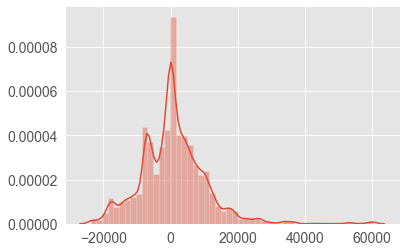

In [286]:
sns.distplot((treatment_effect - control_effect))

#### 8.7

Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  

**Hint:** Look at the distances of the ten nearest neighbors output by `.kneighbors()` for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?

**Answer.**

In [312]:
# At a birds eye-view, we can compare the features importance between RF and DT models estimated to 
# understand why the decision tree regressor performed badly. 

dt_features_imp = pd.concat([pd.DataFrame(cleaned_df.columns), pd.DataFrame(dt.feature_importances_)], axis = 1)
dt_features_imp.columns = ['variable','coef']
dt_features_imp.sort_values(by = ['coef'], ascending = False)

,variable,coef
2,black,0.664049
0,age,0.148598
6,re74,0.134394
4,married,0.037923
7,re75,0.014500
1,educ,0.000535
3,hispan,0.000000
5,nodegree,0.000000


In [313]:
rf_features_imp = pd.concat([pd.DataFrame(cleaned_df.columns), pd.DataFrame(rf.feature_importances_)], axis = 1)
rf_features_imp.columns = ['variable','coef']
rf_features_imp.sort_values(by = ['coef'], ascending = False)

,variable,coef
2,black,0.500469
6,re74,0.178198
0,age,0.100661
7,re75,0.085193
4,married,0.069883
1,educ,0.043064
5,nodegree,0.011441
3,hispan,0.011091


In [ ]:
# Comparing the feature importances of Random Forests and Decision Trees,
# The Decision Trees classifier centered onto few variables like age and black, not considering another covariates
# that are imbalanced: 1. Education Years has a null impact on the score probabilities. 
# 2. Married has a lower importance compared to Random Forests
# This centering effect makes the matching group less reliable to identify the correct output, as we saw in ROC curves.

In [321]:
control_pscores = pscore_tree[treatment == 0].reshape(-1,1)
treat_pscores = pscore_tree[treatment == 1].reshape(-1,1)

knn = neighbors.NearestNeighbors(n_neighbors=10,metric='euclidean')
knn.fit(control_pscores)
kneighbors = pd.DataFrame(knn.kneighbors(treat_pscores, 10, return_distance=False))
kneighbors.columns = ['k1','k2','k3','k4','k5','k6','k7','k8','k9','k10']

matched_control_group = cleaned_df[treatment == 0].reset_index().drop(['index'],axis=1).iloc[np.array(kneighbors['k10']),:]

print("Age: " + str(asmd_covariates('age')))
print("Education Years: " + str(asmd_covariates('educ')))
print("Black (Dummy): " + str(asmd_covariates('black')))
print("Hispan (Dummy): " + str(asmd_covariates('hispan')))
print("Married (Dummy): " + str(asmd_covariates('married')))
print("No-Degree (Dummy): " + str(asmd_covariates('nodegree')))

Age: -0.9058579383092438
Education Years: 2.6624433799463443
Black (Dummy): 0.008722649321100678
Hispan (Dummy): 0.08900765919039101
Married (Dummy): -0.4593998255118468
No-Degree (Dummy): -0.24343407996503252


Age: -0.11792233516451665
Education Years: -1.052593894397392
Black (Dummy): 0.0
Hispan (Dummy): 0.06922817937030412
Married (Dummy): 0.24984902790995178
No-Degree (Dummy): 0.7460076644089703


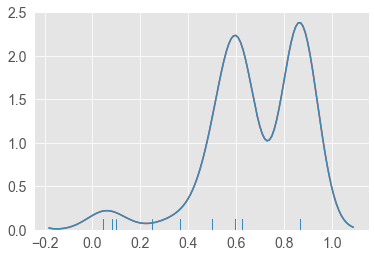

In [322]:
pscore_control_matching = pd.DataFrame(control_pscores).reset_index().drop(['index'],axis=1).iloc[np.array(kneighbors['k1']),:]
pscore_control_matching = np.array(pscore_control_matching)
sns.distplot(pscore_control_matching, hist=False, rug=True)
sns.distplot(treat_pscores, hist=False, rug=True)

matched_control_group = cleaned_df[treatment == 0].reset_index().drop(['index'],axis=1).iloc[np.array(kneighbors['k1']),:]

print("Age: " + str(asmd_covariates('age')))
print("Education Years: " + str(asmd_covariates('educ')))
print("Black (Dummy): " + str(asmd_covariates('black')))
print("Hispan (Dummy): " + str(asmd_covariates('hispan')))
print("Married (Dummy): " + str(asmd_covariates('married')))
print("No-Degree (Dummy): " + str(asmd_covariates('nodegree')))

# Comparing the effect of the 10th nearest neighbor with the 1th, we can see that it affect the covariates and therefore
# the ATE value.